In [59]:
# !pip install mpl_finance
# !pip install yfinance

In [10]:
%matplotlib inline
from lstm import *
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt


from Constants import Consts

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import drive
# drive.mount('/content/drive')

device(type='cpu')

## Adding gold and VIX (Volatility Index) to augment our stock data

In [12]:
prev_5_years = (datetime.today() - timedelta(days=1825)).strftime('%Y-%m-%d')
today = datetime.today().strftime('%Y-%m-%d')

gold_etf = yf.Ticker('GLD')
gold_etf_data = gold_etf.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
gold_etf_data['date_timestamp'] = dates.date2num(gold_etf_data.index)
gold_etf_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2016-02-22,115.440002,116.190002,115.410004,115.489998,10677800,736016.0
2016-02-23,116.680000,117.419998,116.519997,117.220001,9033400,736017.0
2016-02-24,119.000000,119.860001,117.349998,117.610001,17938800,736018.0
2016-02-25,117.620003,118.910004,117.540001,117.919998,12500300,736019.0
2016-02-26,117.430000,117.720001,115.860001,117.110001,12505100,736020.0
...,...,...,...,...,...,...
2021-02-12,170.289993,171.649994,169.880005,170.690002,6016600,737833.0
2021-02-16,168.139999,170.070007,167.729996,168.240005,14720000,737837.0
2021-02-17,166.919998,167.339996,165.850006,166.330002,11400700,737838.0


In [13]:
vix_index = yf.Ticker('^VIX')
vix_data = vix_index.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
vix_data['date_timestamp'] = dates.date2num(vix_data.index)
vix_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2016-02-22,20.139999,20.350000,19.020000,19.379999,0,736016.0
2016-02-23,19.750000,21.160000,19.540001,20.980000,0,736017.0
2016-02-24,22.280001,22.870001,20.260000,20.719999,0,736018.0
2016-02-25,20.540001,21.260000,19.100000,19.110001,0,736019.0
2016-02-26,18.889999,20.129999,18.459999,19.809999,0,736020.0
...,...,...,...,...,...,...
2021-02-12,21.600000,22.450001,19.950001,19.969999,0,737833.0
2021-02-16,21.129999,22.459999,20.879999,21.459999,0,737837.0
2021-02-17,22.020000,23.440001,21.090000,21.500000,0,737838.0


In [14]:
apple = yf.Ticker('AAPL')
apple_data = apple.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
apple_data['date_timestamp'] = dates.date2num(apple_data.index)

first_date = apple_data.iloc[0].name

apple_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2016-02-22,22.394691,22.531883,22.304005,22.527231,137123200,736016.0
2016-02-23,22.415623,22.438875,21.985448,22.018002,127770400,736017.0
2016-02-24,21.852907,22.410971,21.699438,22.345863,145022800,736018.0
2016-02-25,22.334236,22.499331,22.148214,22.499331,110330800,736019.0
2016-02-26,22.601640,22.792312,22.457474,22.534208,115964400,736020.0
...,...,...,...,...,...,...
2021-02-12,134.350006,135.529999,133.690002,135.369995,60029300,737833.0
2021-02-16,135.490005,136.009995,132.789993,133.190002,80206200,737837.0
2021-02-17,131.250000,132.220001,129.470001,130.839996,97918500,737838.0


In [15]:
apple_data['gold_close'] = gold_etf_data.Close
apple_data['vix_close'] = vix_data.Close

In [16]:
apple_data

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close
Date,,,,,,,,
2016-02-22,22.394691,22.531883,22.304005,22.527231,137123200,736016.0,115.489998,19.379999
2016-02-23,22.415623,22.438875,21.985448,22.018002,127770400,736017.0,117.220001,20.980000
2016-02-24,21.852907,22.410971,21.699438,22.345863,145022800,736018.0,117.610001,20.719999
2016-02-25,22.334236,22.499331,22.148214,22.499331,110330800,736019.0,117.919998,19.110001
2016-02-26,22.601640,22.792312,22.457474,22.534208,115964400,736020.0,117.110001,19.809999
...,...,...,...,...,...,...,...,...
2021-02-12,134.350006,135.529999,133.690002,135.369995,60029300,737833.0,170.690002,19.969999
2021-02-16,135.490005,136.009995,132.789993,133.190002,80206200,737837.0,168.240005,21.459999
2021-02-17,131.250000,132.220001,129.470001,130.839996,97918500,737838.0,166.330002,21.500000


In [17]:
apple_close_delta = apple_data.Close.diff()[1:]
apple_close_delta

Date
2016-02-23   -0.509230
2016-02-24    0.327862
2016-02-25    0.153467
2016-02-26    0.034878
2016-02-29   -0.051151
                ...   
2021-02-12    0.239990
2021-02-16   -2.179993
2021-02-17   -2.350006
2021-02-18   -1.129990
2021-02-19    0.159988
Name: Close, Length: 1258, dtype: float64

In [18]:
# Make the positive gains (up) and negative gains (down) Series
up, down = apple_close_delta.copy(), apple_close_delta.copy()
up[up < 0] = 0
down[down > 0] = 0

In [19]:
window_length = 14

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))
RSI1

Date
2016-02-23     0.000000
2016-02-24    42.624061
2016-02-25    53.360923
2016-02-26    55.542516
2016-02-29    51.468517
                ...    
2021-02-12    49.378617
2021-02-16    39.228228
2021-02-17    31.240495
2021-02-18    28.069386
2021-02-19    29.242733
Name: Close, Length: 1258, dtype: float64

In [20]:
try:
    apple_data.drop(index=first_date, inplace=True)
except KeyError:
    pass

In [21]:
apple_data['RSI'] = RSI1
apple_data.head()

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close,RSI
Date,,,,,,,,,
2016-02-23,22.415623,22.438875,21.985448,22.018002,127770400,736017.0,117.220001,20.980000,0.000000
2016-02-24,21.852907,22.410971,21.699438,22.345863,145022800,736018.0,117.610001,20.719999,42.624061
2016-02-25,22.334236,22.499331,22.148214,22.499331,110330800,736019.0,117.919998,19.110001,53.360923
2016-02-26,22.601640,22.792312,22.457474,22.534208,115964400,736020.0,117.110001,19.809999,55.542516
2016-02-29,22.522586,22.841149,22.473756,22.483057,140865200,736023.0,118.639999,20.549999,51.468517


In [22]:
# Create a list of lists where each inner-list represents
# one day's trading history
apple = apple_data[[Consts.DATE_TIMESTAMP, Consts.OPEN, Consts.HIGH, 
                    Consts.LOW, Consts.CLOSE, Consts.VOLUME, 'gold_close', 'vix_close', 'RSI']]
apple_list = apple.values.tolist()

# Plot a candlestick chart for Apples stock

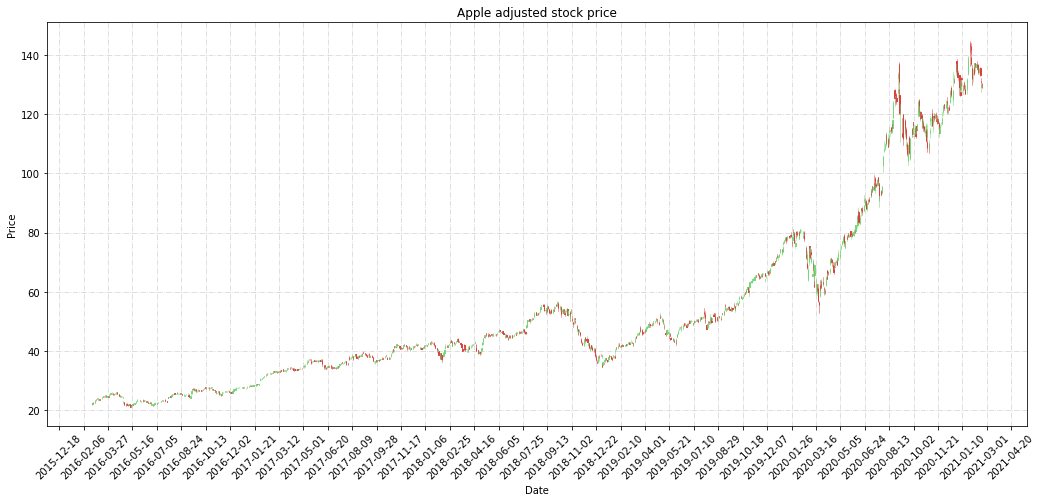

In [23]:

# Build the plot
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,1), (0,0))

candlestick_ohlc(ax1, apple_list, width=0.4, colorup='#77d879', colordown='#db3f3f',)

for label in ax1.xaxis.get_ticklabels():
     label.set_rotation(45)

ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(50))
ax1.grid(True, alpha=0.5, linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple adjusted stock price')
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

# Scaling the data

In [24]:
desired_columns = ['Open', 'High', 'Low', 'Close', 'Volume'] #, 'gold_close', 'vix_close', 'RSI']
close_idx = desired_columns.index('Close')
apple = apple[desired_columns]
apple

,Open,High,Low,Close,Volume
Date,,,,,
2016-02-23,22.415623,22.438875,21.985448,22.018002,127770400
2016-02-24,21.852907,22.410971,21.699438,22.345863,145022800
2016-02-25,22.334236,22.499331,22.148214,22.499331,110330800
2016-02-26,22.601640,22.792312,22.457474,22.534208,115964400
2016-02-29,22.522586,22.841149,22.473756,22.483057,140865200
...,...,...,...,...,...
2021-02-12,134.350006,135.529999,133.690002,135.369995,60029300
2021-02-16,135.490005,136.009995,132.789993,133.190002,80206200
2021-02-17,131.250000,132.220001,129.470001,130.839996,97918500


#### Split the data into training and testing sets

In [25]:
test_size = 365
data = apple.values

train_data = data[:-test_size]
test_data = data[-test_size:]

In [26]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
train_data = torch.FloatTensor(train_data).to(device)

len(train_data), train_data[:3]

(893,
 tensor([[-1.6377, -1.6516, -1.6703, -1.6835,  0.0357],
         [-1.6969, -1.6545, -1.7008, -1.6490,  0.3499],
         [-1.6462, -1.6453, -1.6530, -1.6328, -0.2819]]))

In [27]:
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)
test_data = torch.FloatTensor(test_data).to(device)

len(test_data), test_data[:3]

(365,
 tensor([[-1.4440, -1.4475, -1.4496, -1.4298, -0.2172],
         [-1.4050, -1.3839, -1.3925, -1.3654,  0.5450],
         [-1.3425, -1.3590, -1.3438, -1.3701, -0.1899]]))

# Creating our data for training

In [28]:
# we split the data into 100 day sequences
seq_len = 100
train_seq = create_sequences(train_data, seq_len, close_idx)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 793 training sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [29]:
test_seq = create_sequences(test_data, seq_len, close_idx)
print(f'There are {len(test_seq)} testing sequences where each sequence has a shape of {test_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 265 testing sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [30]:
model = LSTM_linear_before_after(len(desired_columns), 100, 1).to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM_linear_before_after(
  (fc2): Linear(in_features=5, out_features=32, bias=True)
  (lstm): LSTM(32, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)


In [31]:
epochs = 15

loss_history = []
running_loss = []
for i in range(epochs):
    
    for j, (seq, label) in enumerate(train_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device)
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        y_pred = model(seq)

        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []

/Users/dean.meyer/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch   1, iteration     0, loss: 0.04452033519744873
Epoch   1, iteration    50, loss: 0.2245331942603684
Epoch   1, iteration   100, loss: 0.006278632717649089
Epoch   1, iteration   150, loss: 0.00732038500181261
Epoch   1, iteration   200, loss: 0.001905496124334789
Epoch   1, iteration   250, loss: 0.020536821721698288
Epoch   1, iteration   300, loss: 0.027472233653670627
Epoch   1, iteration   350, loss: 0.04616909205034972
Epoch   1, iteration   400, loss: 0.019308397397142015
Epoch   1, iteration   450, loss: 0.04082249662941877
Epoch   1, iteration   500, loss: 0.039479075991407625
Epoch   1, iteration   550, loss: 0.022247401135537075
Epoch   1, iteration   600, loss: 0.03385307781358279
Epoch   1, iteration   650, loss: 0.0702996494450781
Epoch   1, iteration   700, loss: 0.09862374607720995
Epoch   1, iteration   750, loss: 0.08495758824607037
Epoch   2, iteration     0, loss: 0.159680639673968
Epoch   2, iteration    50, loss: 1.099435990078546
Epoch   2, iteration   100,

In [32]:
## save model params
torch.save(model, "Model Info/Model_params")

In [33]:
the_model = torch.load("Model Info/Model_params")

Text(0, 0.5, 'loss')

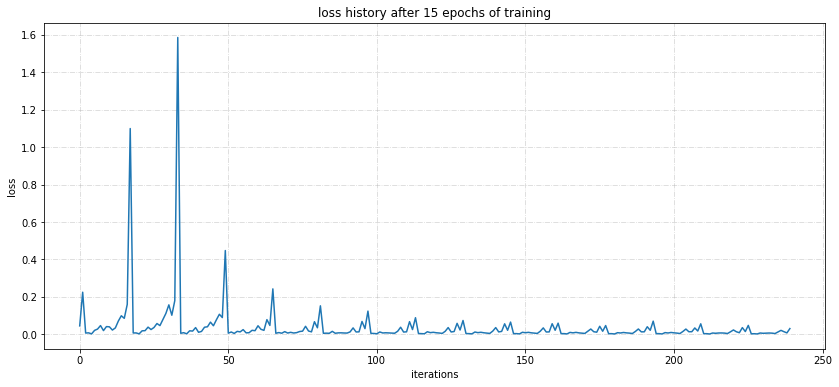

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.title(f'loss history after {epochs} epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')

In [54]:
model = the_model
real_labels = []
predicted_labels = []
saved_values = []

with torch.no_grad():
    for i, (seq, label) in enumerate(test_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device) 
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        # actual price
        real_labels.append(label)
        
        # predicted price
        predicted_labels.append(model(seq))
    
predicted_labels = np.array(predicted_labels)
real_labels = np.array(real_labels)

/Users/dean.meyer/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [55]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_labels, predicted_labels)

0.23021796

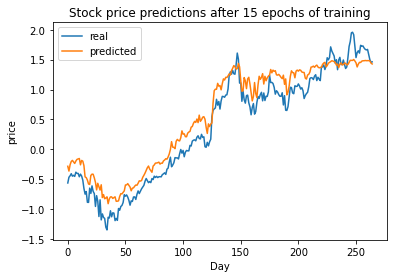

In [56]:

plt.title(f'Stock price predictions after {epochs} epochs of training')
plt.xlabel('Day')
plt.ylabel('price')
plt.plot(real_labels, label='real')
plt.plot(predicted_labels, label='predicted')
plt.legend();

# plt.savefig(f'/content/drive/My Drive/Deep Learning Final Project/{epochs}-epoch-preds1.jpg')

In [57]:
real_prices = real_labels * scaler.scale_[3] + scaler.mean_[3]
predicted_prices = predicted_labels * scaler.scale_[3] + scaler.mean_[3]

In [58]:
real_prices[-5:]

array([135.37, 133.19, 130.84, 129.71, 129.87], dtype=float32)

In [59]:
predicted_prices[-5:]

array([130.41951, 130.4249 , 130.28387, 129.31984, 128.9394 ],
      dtype=float32)

In [60]:
apple

,Open,High,Low,Close,Volume
Date,,,,,
2016-02-23,22.415623,22.438875,21.985448,22.018002,127770400
2016-02-24,21.852907,22.410971,21.699438,22.345863,145022800
2016-02-25,22.334236,22.499331,22.148214,22.499331,110330800
2016-02-26,22.601640,22.792312,22.457474,22.534208,115964400
2016-02-29,22.522586,22.841149,22.473756,22.483057,140865200
...,...,...,...,...,...
2021-02-12,134.350006,135.529999,133.690002,135.369995,60029300
2021-02-16,135.490005,136.009995,132.789993,133.190002,80206200
2021-02-17,131.250000,132.220001,129.470001,130.839996,97918500


In [90]:
days = 180
pred_prices = predicted_prices[:days]
re_prices = real_prices[:days]

print(pred_prices)
print(re_prices)

[ 83.76606   81.64373   84.44296   85.88909   86.36178   85.712616
  85.00924   86.07834   86.80587   86.986626  87.19418   84.40245
  86.340324  86.03832   84.029236  79.07044   78.75802   77.687454
  75.925125  75.73624   79.702896  80.297516  80.231995  78.6445
  76.64437   73.3353    76.23897   74.71411   73.26268   75.59363
  69.94731   71.253555  69.41974   69.76813   70.26486   67.24193
  69.364105  70.23453   70.25981   69.56041   69.89957   70.27501
  68.300415  68.35127   68.48287   70.43082   71.66417   71.57154
  72.27866   72.92816   75.50415   75.53199   76.09502   75.33232
  74.58244   72.93431   74.102844  74.22809   74.95629   75.49324
  75.3876    76.27264   77.334656  77.224976  77.47175   78.87855
  79.76739   80.755455  81.97535   83.11403   83.85754   82.537994
  81.79413   81.11761   83.84548   84.3472    85.16006   85.2007
  85.33223   85.58281   84.7267    85.164734  85.11129   86.139854
  86.528885  87.09902   86.90079   87.86792   89.19217   91.20909
  94.631

In [91]:
from itertools import cycle

# for i in cycle(('sun mon tues wed thur fri'.split(' '))):
#     print(i)

In [94]:
from itertools import cycle

profits_losses = []
bought = []
num_shares = 1
weekly_preds = []


# make a prediction at t=0 for t=1 
for i, (day, today_pred, tom_pred, today_price) in enumerate(zip(cycle(('sun mon tues wed thur fri'.split(' '))), pred_prices[:-1], pred_prices[1:],
                               re_prices[:-1])):
    
        if day == 'thur' and i >= 5:
        
            if tom_pred > pred_prices[i-4]:        
                bought.append(num_shares * today_price)
                
        if day == 'fri' and i >= 11:
            profits_losses.append(today_price - bought[-2])
    

sun
mon
tues
wed
thur
fri
sun
mon
tues
wed
thur
fri


IndexError: list index out of range

In [85]:
sum(profits_losses)

-1.4760589599609375